In [1]:
import zipfile as zf
files = zf.ZipFile("ouput_2007.zip", 'r')
files.extractall('./ouput_2007')
files.close()

FileNotFoundError: [Errno 2] No such file or directory: 'ouput_2007.zip'

## Connect to AWS S3 Bucket

In [1]:
#in cmd (or putty)
aws configure
AWS Access Key ID [None]: input your access key
AWS Secret Access Key [None]: input your secret access key
Default region name [None]: input your region
Default output format [None]: json

aws s3 ls #to verify

In [89]:
import boto3
import botocore

### Download File from S3 Bucket

In [ ]:
Bucket = "capstoneproject-770851433061"
Key = "eurfinaldec4.csv" #"Name of the file in S3 that you want to download"
outPutName = "eurfinaldec4.csv" #The name you want to save after we download from s3
s3 = boto3.resource('s3')
try:
    s3.Bucket(Bucket).download_file(Key, outPutName)
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == "404":
        print("The object does not exist.")
    else:
        raise

### Upload File to S3 Bucket

In [ ]:
bucketName = "capstoneproject-770851433061"
Key = "Original Name"  #"Original Name you want to upload into s3"
outPutname = "Output file name" #(The name you want to give to the file after we upload to s3)

s3 = boto3.client('s3')
s3.upload_file(Key,bucketName,outPutname)

## Data compilation

In [3]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import skew
from sklearn.preprocessing import normalize

plt.style.use('ggplot')

In [4]:
pd.options.display.max_columns=300 #increase columns shown 

In [7]:
# Save the dataset
#dataset.to_csv("./data/dataset.csv", index=False)

## Load Dataset

In [5]:
df = pd.read_csv("./data/eurfinaldec4.csv")

In [4]:
#df.shape

(4447980, 48)

In [7]:
df.columns

Index(['Bar', 'Range', 'Date', 'Timestamp', 'Close', 'UpCount', 'DownCount',
       'Body', 'TopWick', 'BottomWick', 'EURVolume', 'JPYClose', 'JPYRange',
       'JPYVolume', 'CHFClose', 'CHFRange', 'CHFVolume', 'XAUClose',
       'XAURange', 'XAUVolume', 'forceindex', 'WillR5', 'WillR10', 'WillR15',
       'RSI5', 'RSI10', 'RSI15', 'ROC5', 'ROC10', 'MOM5', 'MOM10', 'ATR5',
       'ATR10', 'ADX.DIp', 'ADX.DIn', 'ADX.DX', 'ADX', 'SAR', 'Stoch.fastK',
       'Stoch.fastD', 'Stoch.slowD', 'BBands.dn', 'BBandsm.avg', 'BBands.up',
       'BBands.pctB', 'MACD', 'MACD.Signal', 'MACD.Signal2'],
      dtype='object')

In [72]:
#df.head()

,Bar,Range,Date,Timestamp,Close,UpCount,DownCount,Body,TopWick,BottomWick,EURVolume,JPYClose,JPYRange,JPYVolume,CHFClose,CHFRange,CHFVolume,XAUClose,XAURange,XAUVolume,forceindex,WillR5,WillR10,WillR15,RSI5,RSI10,RSI15,ROC5,ROC10,MOM5,MOM10,ATR5,ATR10,ADX.DIp,ADX.DIn,ADX.DX,ADX,SAR,Stoch.fastK,Stoch.fastD,Stoch.slowD,BBands.dn,BBandsm.avg,BBands.up,BBands.pctB,MACD,MACD.Signal,MACD.Signal2
0,Down,0.00020,2006-12-31,19:33:00,1.31901,NaN,2.0,-0.00009,-0.00009,-0.00007,856.700013,119.020,-0.013,233.900002,1.21883,0.00005,79.599999,635.49,-0.662,0.02112,-0.077103,0.857143,0.857143,0.857143,27.601810,35.618480,40.270270,-0.009855,-0.009097,-0.00013,-0.00012,0.00025,0.00025,12.388902,17.454997,16.975313,13.014355,1.319430,0.142857,0.301192,0.372923,1.318985,1.319258,1.319531,0.113396,-0.007148,-0.007915,Buy
1,Up,0.00020,2006-12-31,19:34:00,1.31917,NaN,3.0,-0.00002,-0.00013,-0.00005,593.200000,119.025,0.011,217.599998,1.21884,-0.00013,121.299998,NaN,NaN,NaN,-0.011864,0.530612,0.530612,0.530612,48.750000,48.539638,49.211564,0.003032,-0.004548,0.00004,-0.00006,0.00031,0.00031,15.117079,15.843294,2.345627,11.591858,1.319410,0.469388,0.385290,0.379107,1.318993,1.319243,1.319493,0.420580,-0.006785,-0.007689,Buy
2,Up,0.00022,2006-12-31,19:35:00,1.31925,1.0,NaN,0.00014,0.00005,0.00001,1003.100010,119.032,0.020,284.500000,1.21882,0.00014,276.899997,NaN,NaN,NaN,0.140434,0.367347,0.367347,0.367347,57.352941,54.772394,53.770950,0.000758,0.009855,0.00001,0.00013,0.00020,0.00020,14.205736,15.491027,4.328052,10.623350,1.319392,0.632653,0.508971,0.444039,1.319004,1.319230,1.319456,0.470452,-0.005939,-0.007339,Buy
3,Up,0.00022,2006-12-31,19:36:00,1.31924,2.0,NaN,0.00018,0.00004,0.00000,644.400001,119.024,-0.015,202.800000,1.21878,-0.00017,39.800000,NaN,NaN,NaN,0.115992,0.210526,0.387755,0.387755,58.823529,53.645833,52.786624,-0.009853,-0.003032,-0.00013,-0.00004,0.00022,0.00022,13.258850,15.670382,8.335968,10.318366,1.319374,0.612245,0.560608,0.502324,1.319024,1.319215,1.319406,0.443223,-0.005269,-0.006925,Buy
4,Down,0.00029,2006-12-31,19:37:00,1.31926,3.0,NaN,0.00012,0.00007,0.00003,686.399999,119.019,-0.010,170.000003,1.21882,0.00008,168.900000,NaN,NaN,NaN,0.082368,0.179487,0.346939,0.346939,77.647059,56.653226,54.844444,0.007581,0.002274,0.00010,0.00003,0.00022,0.00022,13.892996,14.620861,2.552668,9.282940,1.319356,0.653061,0.606835,0.554579,1.319057,1.319202,1.319347,0.606778,-0.004564,-0.006453,Buy


In [6]:
#delete Bar column
df = df.drop('Bar', 1) #1 for columns

In [75]:
#abs value
#df['Body'] = df['Body'].abs()
#df['TopWick'] = df['TopWick'].abs()
#df['BottomWick'] = df['BottomWick'].abs()
#df['JPYRange'] = df['JPYRange'].abs()
#df['CHFRange'] = df['CHFRange'].abs()
#df['XAURange'] = df['XAURange'].abs()

In [7]:
#get abs value
df.iloc[:,6:46] = df.iloc[:,6:46].abs()

In [8]:
#impute some missing values
df.loc[:, "UpCount"] = df.loc[:, "UpCount"].fillna("0")
df.loc[:, "DownCount"] = df.loc[:, "DownCount"].fillna("0")

In [11]:
df.head()

,Range,Date,Timestamp,Close,UpCount,DownCount,Body,TopWick,BottomWick,EURVolume,JPYClose,JPYRange,JPYVolume,CHFClose,CHFRange,CHFVolume,XAUClose,XAURange,XAUVolume,forceindex,WillR5,WillR10,WillR15,RSI5,RSI10,RSI15,ROC5,ROC10,MOM5,MOM10,ATR5,ATR10,ADX.DIp,ADX.DIn,ADX.DX,ADX,SAR,Stoch.fastK,Stoch.fastD,Stoch.slowD,BBands.dn,BBandsm.avg,BBands.up,BBands.pctB,MACD,MACD.Signal,MACD.Signal2
0,0.00020,2006-12-31,19:33:00,1.31901,0,2,0.00009,0.00009,0.00007,856.700013,119.020,0.013,233.900002,1.21883,0.00005,79.599999,635.49,0.662,0.02112,0.077103,0.857143,0.857143,0.857143,27.601810,35.618480,40.270270,0.009855,0.009097,0.00013,0.00012,0.00025,0.00025,12.388902,17.454997,16.975313,13.014355,1.319430,0.142857,0.301192,0.372923,1.318985,1.319258,1.319531,0.113396,0.007148,0.007915,Buy
1,0.00020,2006-12-31,19:34:00,1.31917,0,3,0.00002,0.00013,0.00005,593.200000,119.025,0.011,217.599998,1.21884,0.00013,121.299998,NaN,NaN,NaN,0.011864,0.530612,0.530612,0.530612,48.750000,48.539638,49.211564,0.003032,0.004548,0.00004,0.00006,0.00031,0.00031,15.117079,15.843294,2.345627,11.591858,1.319410,0.469388,0.385290,0.379107,1.318993,1.319243,1.319493,0.420580,0.006785,0.007689,Buy
2,0.00022,2006-12-31,19:35:00,1.31925,1,0,0.00014,0.00005,0.00001,1003.100010,119.032,0.020,284.500000,1.21882,0.00014,276.899997,NaN,NaN,NaN,0.140434,0.367347,0.367347,0.367347,57.352941,54.772394,53.770950,0.000758,0.009855,0.00001,0.00013,0.00020,0.00020,14.205736,15.491027,4.328052,10.623350,1.319392,0.632653,0.508971,0.444039,1.319004,1.319230,1.319456,0.470452,0.005939,0.007339,Buy
3,0.00022,2006-12-31,19:36:00,1.31924,2,0,0.00018,0.00004,0.00000,644.400001,119.024,0.015,202.800000,1.21878,0.00017,39.800000,NaN,NaN,NaN,0.115992,0.210526,0.387755,0.387755,58.823529,53.645833,52.786624,0.009853,0.003032,0.00013,0.00004,0.00022,0.00022,13.258850,15.670382,8.335968,10.318366,1.319374,0.612245,0.560608,0.502324,1.319024,1.319215,1.319406,0.443223,0.005269,0.006925,Buy
4,0.00029,2006-12-31,19:37:00,1.31926,3,0,0.00012,0.00007,0.00003,686.399999,119.019,0.010,170.000003,1.21882,0.00008,168.900000,NaN,NaN,NaN,0.082368,0.179487,0.346939,0.346939,77.647059,56.653226,54.844444,0.007581,0.002274,0.00010,0.00003,0.00022,0.00022,13.892996,14.620861,2.552668,9.282940,1.319356,0.653061,0.606835,0.554579,1.319057,1.319202,1.319347,0.606778,0.004564,0.006453,Buy


## Set Dates

In [10]:
df['Date'][0:3]

0    2006-12-31
1    2006-12-31
2    2006-12-31
Name: Date, dtype: object

In [9]:
#need to be able to choose year for years
#https://stackoverflow.com/questions/30405413/python-pandas-extract-year-from-datetime-dfyear-dfdate-year-is-not/33757291
df['Date'] = pd.to_datetime(df['Date'])

In [53]:
df['Date'][0:3]

0   2006-12-31
1   2006-12-31
2   2006-12-31
Name: Date, dtype: datetime64[ns]

In [57]:
eur2007 = df[df['Date'].dt.year == 2007]

In [58]:
eur2007.shape

(375801, 47)

In [59]:
eur2007.head()

,Range,Date,Timestamp,Close,UpCount,DownCount,Body,TopWick,BottomWick,EURVolume,JPYClose,JPYRange,JPYVolume,CHFClose,CHFRange,CHFVolume,XAUClose,XAURange,XAUVolume,forceindex,WillR5,WillR10,WillR15,RSI5,RSI10,RSI15,ROC5,ROC10,MOM5,MOM10,ATR5,ATR10,ADX.DIp,ADX.DIn,ADX.DX,ADX,SAR,Stoch.fastK,Stoch.fastD,Stoch.slowD,BBands.dn,BBandsm.avg,BBands.up,BBands.pctB,MACD,MACD.Signal,MACD.Signal2
267,0.00021,2007-01-01,00:00:00,1.31926,0,1,0.00016,0.00000,0.00002,328.900006,119.013,0.003,94.100002,1.21880,0.00006,50.699999,635.665,0.604,0.02340,0.052624,0.3600,0.36,0.36,47.058824,50.246305,53.617021,0.000000,0.003790,0.00000,0.00005,0.00018,0.00018,12.303177,13.411366,4.309582,11.313842,1.318940,0.64,0.683297,0.682029,1.319097,1.319218,1.319340,0.862827,0.001271,0.000161,Buy
268,0.00031,2007-01-01,00:01:00,1.31930,1,0,0.00003,0.00010,0.00008,808.499999,119.022,0.013,305.500006,1.21887,0.00007,140.600003,NaN,NaN,NaN,0.024255,0.2500,0.28,0.28,60.563380,55.068493,56.172140,0.010613,0.009855,0.00014,0.00013,0.00021,0.00021,11.543955,14.053031,9.802231,11.112294,1.318940,0.72,0.701648,0.691839,1.319095,1.319221,1.319347,0.799097,0.001466,0.000422,Buy
269,0.00020,2007-01-01,00:02:00,1.31934,2,0,0.00016,0.00007,0.00008,863.200007,119.015,0.016,178.300001,1.21878,0.00002,41.100000,635.503,0.603,0.02084,0.138112,0.2500,0.20,0.20,66.666667,59.876543,59.227986,0.003790,0.007580,0.00005,0.00010,0.00031,0.00031,10.512642,15.391244,18.833474,12.141784,1.318959,0.80,0.750824,0.721331,1.319114,1.319230,1.319347,0.727911,0.001844,0.000706,Buy
270,0.00023,2007-01-01,00:03:00,1.31922,0,1,0.00009,0.00011,0.00000,907.400007,119.005,0.015,345.300005,1.21890,0.00012,182.600002,NaN,NaN,NaN,0.081666,0.6250,0.44,0.44,28.846154,40.983607,47.480403,0.006822,0.012885,0.00009,0.00017,0.00020,0.00020,10.190465,14.491728,17.426584,12.846424,1.318978,0.56,0.655412,0.688372,1.319127,1.319238,1.319349,0.720845,0.001393,0.000843,Buy
271,0.00025,2007-01-01,00:04:00,1.31928,0,2,0.00004,0.00008,0.00011,558.000005,119.003,0.017,355.800001,1.21879,0.00012,144.500002,635.850,0.668,0.02756,0.022320,0.4375,0.32,0.32,47.619048,51.566952,52.447552,0.003790,0.004548,0.00005,0.00006,0.00023,0.00023,9.502663,14.980888,22.375124,14.116918,1.318995,0.68,0.667706,0.678039,1.319133,1.319243,1.319352,0.685356,0.001387,0.000952,Buy


## Imputation of missingness

First, we analyze the missing values in our dataset and impute them.

In [60]:
#missing data
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

missing_data[missing_data['Total'].values> 0]

,Total,Percent
XAUVolume,215718,0.048498
XAURange,215718,0.048498
XAUClose,215718,0.048498
JPYRange,41566,0.009345
JPYClose,41566,0.009345
JPYVolume,41566,0.009345
CHFVolume,10458,0.002351
CHFRange,10458,0.002351
CHFClose,10458,0.002351
RSI5,1469,0.000330


XAU missing data is due to market hours being shorter than FX hours

In [65]:
#a look at RSI 15 rows with missing data
null_data = df[df['RSI15'].isnull()]
null_data.head()

,Range,Date,Timestamp,Close,UpCount,DownCount,Body,TopWick,BottomWick,EURVolume,JPYClose,JPYRange,JPYVolume,CHFClose,CHFRange,CHFVolume,XAUClose,XAURange,XAUVolume,forceindex,WillR5,WillR10,WillR15,RSI5,RSI10,RSI15,ROC5,ROC10,MOM5,MOM10,ATR5,ATR10,ADX.DIp,ADX.DIn,ADX.DX,ADX,SAR,Stoch.fastK,Stoch.fastD,Stoch.slowD,BBands.dn,BBandsm.avg,BBands.up,BBands.pctB,MACD,MACD.Signal,MACD.Signal2
104658,0.00010,2007-04-11,11:51:00,1.3437,0,0,0.0,0.0,0.00000,208.9,119.325,0.015,482.4,1.21910,0.00020,264.0,676.522,0.699,0.00318,0.0,0.5,1.0,0.5,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.00000,0.00000,21.944580,18.12231,9.539718,9.239929,1.343685,0.4,0.450194,0.476065,1.343631,1.343703,1.343775,0.476838,0.001972,0.002503,Sell
109134,0.00005,2007-04-16,14:27:00,1.3547,0,0,0.0,0.0,0.00000,307.9,119.760,0.010,322.3,1.21380,0.00000,98.4,690.088,0.119,0.00475,0.0,0.5,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.00000,0.00000,10.616680,35.72592,54.181770,52.075150,1.354646,1.0,0.968987,0.907656,1.354674,1.354693,1.354713,0.671499,0.000853,0.001256,Buy
109135,0.00005,2007-04-16,14:28:00,1.3547,0,0,0.0,0.0,0.00005,416.5,119.755,0.020,638.2,1.21380,0.00000,49.0,690.133,0.163,0.00596,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.00005,0.00005,9.406164,43.05447,64.140100,53.683810,1.354650,1.0,0.984494,0.946075,1.354673,1.354692,1.354712,0.266748,0.000787,0.001162,Buy
109136,0.00010,2007-04-16,14:29:00,1.3547,0,0,0.0,0.0,0.00005,701.3,119.760,0.010,186.1,1.21380,0.00000,27.0,690.106,0.079,0.00470,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.00005,0.00005,8.377485,38.34593,64.140100,55.077990,1.354750,1.0,0.992247,0.969161,1.354673,1.354692,1.354712,0.266748,0.000726,0.001075,Buy
3739103,0.00000,2016-12-26,12:26:00,1.0450,0,0,0.0,0.0,0.00000,24.3,117.048,0.006,8.4,1.02676,0.00001,7.0,NaN,NaN,NaN,0.0,0.5,0.5,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.00000,0.00000,25.895300,36.58675,17.111240,18.088700,1.044867,1.0,0.999615,0.998213,1.044887,1.044971,1.045056,0.667655,0.002686,0.003175,Sell


In [66]:
df[104655:104660]

,Range,Date,Timestamp,Close,UpCount,DownCount,Body,TopWick,BottomWick,EURVolume,JPYClose,JPYRange,JPYVolume,CHFClose,CHFRange,CHFVolume,XAUClose,XAURange,XAUVolume,forceindex,WillR5,WillR10,WillR15,RSI5,RSI10,RSI15,ROC5,ROC10,MOM5,MOM10,ATR5,ATR10,ADX.DIp,ADX.DIn,ADX.DX,ADX,SAR,Stoch.fastK,Stoch.fastD,Stoch.slowD,BBands.dn,BBandsm.avg,BBands.up,BBands.pctB,MACD,MACD.Signal,MACD.Signal2
104655,0.0000,2007-04-11,11:48:00,1.3437,0,0,0.0000,0.0,0.0,290.0,119.335,0.015,230.5,1.21900,0.0001,188.8,676.048,0.847,0.00485,0.0000,0.5,0.6,0.5,NaN,NaN,60.0,0.000000,0.000000,0.0000,0.0000,0.0000,0.0000,21.94458,18.12231,9.539718,9.079187,1.343651,0.5,0.501552,0.506190,1.343607,1.343694,1.343781,0.533487,0.002377,0.002902,Sell
104656,0.0000,2007-04-11,11:49:00,1.3437,0,0,0.0000,0.0,0.0,145.0,119.340,0.010,351.8,1.21920,0.0002,243.5,676.220,0.878,0.00304,0.0000,0.5,0.6,0.5,NaN,NaN,80.0,0.000000,0.000000,0.0000,0.0000,0.0000,0.0000,21.94458,18.12231,9.539718,9.140591,1.343663,0.5,0.500776,0.503483,1.343619,1.343698,1.343778,0.510481,0.002237,0.002769,Sell
104657,0.0000,2007-04-11,11:50:00,1.3437,0,0,0.0000,0.0,0.0,10.5,119.335,0.005,186.2,1.21930,0.0001,282.0,676.397,0.945,0.00410,0.0000,0.5,0.6,0.5,NaN,NaN,100.0,0.000000,0.000000,0.0000,0.0000,0.0000,0.0000,21.94458,18.12231,9.539718,9.193808,1.343674,0.5,0.500388,0.501936,1.343628,1.343702,1.343775,0.488695,0.002102,0.002636,Sell
104658,0.0001,2007-04-11,11:51:00,1.3437,0,0,0.0000,0.0,0.0,208.9,119.325,0.015,482.4,1.21910,0.0002,264.0,676.522,0.699,0.00318,0.0000,0.5,1.0,0.5,NaN,NaN,NaN,0.000000,0.000000,0.0000,0.0000,0.0000,0.0000,21.94458,18.12231,9.539718,9.239929,1.343685,0.4,0.450194,0.476065,1.343631,1.343703,1.343775,0.476838,0.001972,0.002503,Sell
104659,0.0000,2007-04-11,11:52:00,1.3436,0,1,0.0001,0.0,0.0,27.0,119.350,0.015,374.4,1.21935,0.0003,829.5,676.207,0.574,0.00381,0.0027,1.0,1.0,1.0,0.0,0.0,0.0,0.007442,0.007442,0.0001,0.0001,0.0001,0.0001,19.67400,26.59409,14.956520,10.002140,1.343850,0.0,0.225097,0.350581,1.343623,1.343697,1.343772,0.070736,0.001254,0.002253,Sell


RSI15 values missing due to?

In [10]:
#drop NA values
df = df.dropna()
#reset index
df = df.reset_index(drop=True)

In [11]:
df.head()

,Range,Date,Timestamp,Close,UpCount,DownCount,Body,TopWick,BottomWick,EURVolume,JPYClose,JPYRange,JPYVolume,CHFClose,CHFRange,CHFVolume,XAUClose,XAURange,XAUVolume,forceindex,WillR5,WillR10,WillR15,RSI5,RSI10,RSI15,ROC5,ROC10,MOM5,MOM10,ATR5,ATR10,ADX.DIp,ADX.DIn,ADX.DX,ADX,SAR,Stoch.fastK,Stoch.fastD,Stoch.slowD,BBands.dn,BBandsm.avg,BBands.up,BBands.pctB,MACD,MACD.Signal,MACD.Signal2
0,0.00020,2006-12-31,19:33:00,1.31901,0,2,0.00009,0.00009,0.00007,856.700013,119.020,0.013,233.900002,1.21883,0.00005,79.599999,635.490,0.662,0.02112,0.077103,0.857143,0.857143,0.857143,27.601810,35.618480,40.270270,0.009855,0.009097,0.00013,0.00012,0.00025,0.00025,12.388902,17.454997,16.975313,13.014355,1.319430,0.142857,0.301192,0.372923,1.318985,1.319258,1.319531,0.113396,0.007148,0.007915,Buy
1,0.00020,2006-12-31,19:40:00,1.31925,1,0,0.00008,0.00004,0.00006,916.300005,119.025,0.009,397.500010,1.21885,0.00015,126.200000,635.492,0.665,0.01873,0.073304,0.210526,0.367347,0.367347,61.344538,55.900621,54.107143,0.000000,0.000758,0.00000,0.00001,0.00018,0.00018,11.809940,15.745073,14.281005,11.211946,1.319308,0.632653,0.527385,0.498155,1.319057,1.319191,1.319325,0.595242,0.004238,0.005572,Buy
2,0.00025,2006-12-31,19:42:00,1.31918,0,2,0.00009,0.00005,0.00002,426.699995,119.025,0.017,322.199997,1.21875,0.00015,112.400001,635.676,0.583,0.02072,0.038403,0.378378,0.384615,0.510204,50.000000,50.904393,49.298597,0.006064,0.001516,0.00008,0.00002,0.00016,0.00016,11.165577,14.348379,12.474752,11.849264,1.318940,0.489796,0.488989,0.491079,1.319064,1.319192,1.319321,0.607481,0.003909,0.005012,Buy
3,0.00022,2006-12-31,19:43:00,1.31910,0,3,0.00004,0.00016,0.00005,943.199994,119.008,0.020,186.000003,1.21879,0.00013,217.699998,635.583,0.674,0.01871,0.037728,0.594595,0.605263,0.673469,34.313725,40.259740,43.425076,0.000758,0.006823,0.00001,0.00009,0.00025,0.00025,10.307095,16.628187,23.467701,13.398389,1.318940,0.326531,0.407760,0.449419,1.319073,1.319195,1.319317,0.315182,0.004161,0.004842,Buy
4,0.00026,2006-12-31,19:44:00,1.31928,1,0,0.00014,0.00007,0.00001,819.400003,119.023,0.006,173.799998,1.21882,0.00008,126.800000,635.550,0.577,0.00735,0.114716,0.233333,0.175000,0.306122,68.553459,59.795918,56.502242,0.012129,0.008339,0.00016,0.00011,0.00025,0.00025,11.048303,15.356645,16.316419,13.787460,1.318955,0.693878,0.550819,0.500119,1.319073,1.319198,1.319322,0.723803,0.003223,0.004518,Buy


In [11]:
df.shape #(4196698, 47)

(4196698, 47)

Check that there are no more missing values

In [12]:
dataset = df
#let's take a look at the data now
total = dataset.isnull().sum().sort_values(ascending=False)
percent = (dataset.isnull().sum()/dataset.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

missing_data[missing_data['Total'].values> 0]

,Total,Percent


## Create one hot representation

In [61]:
df = dataset

In [15]:
# Differentiate numerical features (minus the target) and categorical features
categorical = df.select_dtypes(include = ["object", "datetime64[ns]"]).columns
categorical = categorical.drop(["Timestamp", "Date"])
numerical = df.select_dtypes(exclude = ["object", "datetime64[ns]"]).columns
numerical = numerical.drop("Range")
print("Numerical features : " + str(len(numerical)))
print("Categorical features : " + str(len(categorical)))
#train_num = train[numerical_features]
#train_cat = train[categorical_features]

Numerical features : 41
Categorical features : 3


In [23]:
numerical

Index(['Close', 'Body', 'TopWick', 'BottomWick', 'EURVolume', 'JPYClose',
       'JPYRange', 'JPYVolume', 'CHFClose', 'CHFRange', 'CHFVolume',
       'XAUClose', 'XAURange', 'XAUVolume', 'forceindex', 'WillR5', 'WillR10',
       'WillR15', 'RSI5', 'RSI10', 'RSI15', 'ROC5', 'ROC10', 'MOM5', 'MOM10',
       'ATR5', 'ATR10', 'ADX.DIp', 'ADX.DIn', 'ADX.DX', 'ADX', 'SAR',
       'Stoch.fastK', 'Stoch.fastD', 'Stoch.slowD', 'BBands.dn', 'BBandsm.avg',
       'BBands.up', 'BBands.pctB', 'MACD', 'MACD.Signal'],
      dtype='object')

In [16]:
#categorical= categorical.drop("Date") #drop Date
categorical

Index(['UpCount', 'DownCount', 'MACD.Signal2'], dtype='object')

In [22]:
# Find most important features relative to target, then take this again after log
print("Find most important features relative to target")
corr = df.corr()
corr.sort_values(["Range"], ascending = False, inplace = True)
print(corr.Range)

Find most important features relative to target
Range          1.000000
ATR5           0.722607
ATR10          0.722607
BottomWick     0.552216
TopWick        0.514702
CHFRange       0.456709
Body           0.432882
MOM5           0.429441
MOM10          0.427524
ROC5           0.402341
ROC10          0.400415
MACD           0.381493
BBands.up      0.378137
Close          0.376376
BBandsm.avg    0.376356
SAR            0.376332
BBands.dn      0.374567
MACD.Signal    0.361062
JPYRange       0.357582
forceindex     0.332717
CHFClose       0.303909
XAURange       0.251203
EURVolume      0.211880
CHFVolume      0.180041
JPYVolume      0.142088
ADX.DX         0.073886
ADX            0.056333
Stoch.fastK    0.015135
Stoch.fastD    0.015075
Stoch.slowD    0.014859
BBands.pctB    0.009650
RSI5           0.002400
RSI10          0.000364
RSI15         -0.000836
WillR15       -0.014538
WillR10       -0.018465
WillR5        -0.025916
XAUVolume     -0.060127
JPYClose      -0.151227
XAUClose      -0

Pickle list of types

In [17]:
# Exclude Sales price from numerical list
pickle.dump(numerical, open('./tmp/numerical.list', 'wb'))
pickle.dump(categorical, open('./tmp/categorical.list', 'wb'))

Create one hot vector of numerical

In [18]:
# Create dummies
one_hot_data = pd.get_dummies(df[categorical],drop_first=True)

#Drop categorical
df = df.drop(categorical, axis=1)

# Merge with one hot
df = df.join(one_hot_data)
#df.shape

In [19]:
one_hot_data.head()

,UpCount_2.0,UpCount_3.0,UpCount_4.0,UpCount_5.0,UpCount_6.0,UpCount_7.0,UpCount_8.0,UpCount_9.0,UpCount_10.0,UpCount_11.0,UpCount_12.0,UpCount_13.0,UpCount_14.0,UpCount_15.0,UpCount_16.0,UpCount_17.0,UpCount_18.0,UpCount_19.0,UpCount_0,DownCount_2.0,DownCount_3.0,DownCount_4.0,DownCount_5.0,DownCount_6.0,DownCount_7.0,DownCount_8.0,DownCount_9.0,DownCount_10.0,DownCount_11.0,DownCount_12.0,DownCount_13.0,DownCount_14.0,DownCount_15.0,DownCount_16.0,DownCount_17.0,DownCount_18.0,DownCount_19.0,DownCount_20.0,DownCount_21.0,DownCount_0,MACD.Signal2_Sell
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [20]:
df.head()

,Range,Date,Timestamp,Close,Body,TopWick,BottomWick,EURVolume,JPYClose,JPYRange,JPYVolume,CHFClose,CHFRange,CHFVolume,XAUClose,XAURange,XAUVolume,forceindex,WillR5,WillR10,WillR15,RSI5,RSI10,RSI15,ROC5,ROC10,MOM5,MOM10,ATR5,ATR10,ADX.DIp,ADX.DIn,ADX.DX,ADX,SAR,Stoch.fastK,Stoch.fastD,Stoch.slowD,BBands.dn,BBandsm.avg,BBands.up,BBands.pctB,MACD,MACD.Signal,UpCount_2.0,UpCount_3.0,UpCount_4.0,UpCount_5.0,UpCount_6.0,UpCount_7.0,UpCount_8.0,UpCount_9.0,UpCount_10.0,UpCount_11.0,UpCount_12.0,UpCount_13.0,UpCount_14.0,UpCount_15.0,UpCount_16.0,UpCount_17.0,UpCount_18.0,UpCount_19.0,UpCount_0,DownCount_2.0,DownCount_3.0,DownCount_4.0,DownCount_5.0,DownCount_6.0,DownCount_7.0,DownCount_8.0,DownCount_9.0,DownCount_10.0,DownCount_11.0,DownCount_12.0,DownCount_13.0,DownCount_14.0,DownCount_15.0,DownCount_16.0,DownCount_17.0,DownCount_18.0,DownCount_19.0,DownCount_20.0,DownCount_21.0,DownCount_0,MACD.Signal2_Sell
0,0.00020,2006-12-31,19:33:00,1.31901,0.00009,0.00009,0.00007,856.700013,119.020,0.013,233.900002,1.21883,0.00005,79.599999,635.490,0.662,0.02112,0.077103,0.857143,0.857143,0.857143,27.601810,35.618480,40.270270,0.009855,0.009097,0.00013,0.00012,0.00025,0.00025,12.388902,17.454997,16.975313,13.014355,1.319430,0.142857,0.301192,0.372923,1.318985,1.319258,1.319531,0.113396,0.007148,0.007915,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.00020,2006-12-31,19:40:00,1.31925,0.00008,0.00004,0.00006,916.300005,119.025,0.009,397.500010,1.21885,0.00015,126.200000,635.492,0.665,0.01873,0.073304,0.210526,0.367347,0.367347,61.344538,55.900621,54.107143,0.000000,0.000758,0.00000,0.00001,0.00018,0.00018,11.809940,15.745073,14.281005,11.211946,1.319308,0.632653,0.527385,0.498155,1.319057,1.319191,1.319325,0.595242,0.004238,0.005572,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0.00025,2006-12-31,19:42:00,1.31918,0.00009,0.00005,0.00002,426.699995,119.025,0.017,322.199997,1.21875,0.00015,112.400001,635.676,0.583,0.02072,0.038403,0.378378,0.384615,0.510204,50.000000,50.904393,49.298597,0.006064,0.001516,0.00008,0.00002,0.00016,0.00016,11.165577,14.348379,12.474752,11.849264,1.318940,0.489796,0.488989,0.491079,1.319064,1.319192,1.319321,0.607481,0.003909,0.005012,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.00022,2006-12-31,19:43:00,1.31910,0.00004,0.00016,0.00005,943.199994,119.008,0.020,186.000003,1.21879,0.00013,217.699998,635.583,0.674,0.01871,0.037728,0.594595,0.605263,0.673469,34.313725,40.259740,43.425076,0.000758,0.006823,0.00001,0.00009,0.00025,0.00025,10.307095,16.628187,23.467701,13.398389,1.318940,0.326531,0.407760,0.449419,1.319073,1.319195,1.319317,0.315182,0.004161,0.004842,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.00026,2006-12-31,19:44:00,1.31928,0.00014,0.00007,0.00001,819.400003,119.023,0.006,173.799998,1.21882,0.00008,126.800000,635.550,0.577,0.00735,0.114716,0.233333,0.175000,0.306122,68.553459,59.795918,56.502242,0.012129,0.008339,0.00016,0.00011,0.00025,0.00025,11.048303,15.356645,16.316419,13.787460,1.318955,0.693878,0.550819,0.500119,1.319073,1.319198,1.319322,0.723803,0.003223,0.004518,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [21]:
df.shape #(4196698, 85)

(4196698, 85)

## Graphing Range (pips)

For our models we choose whether to use the regular values or the log of them. Let's look at the distribution of the ranges in our dataset.

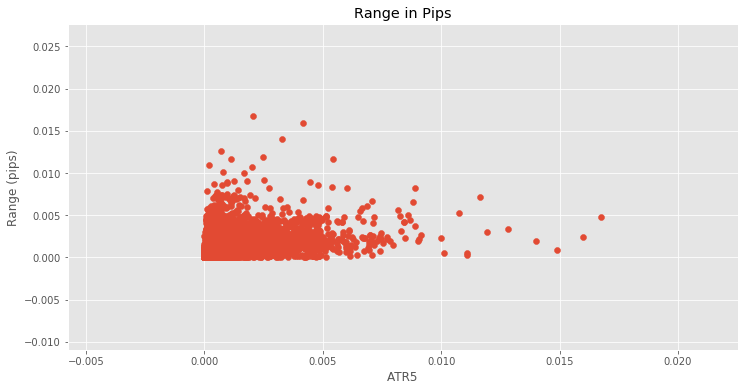

In [109]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
Ranges = pd.DataFrame({"Range (pips)":Range})
Ranges = Ranges.join(pd.DataFrame({'ATR5':df.ATR5}))

plt.scatter(Ranges['ATR5'], Ranges['Range (pips)'])
plt.ylabel('Range (pips)')
plt.xlabel('ATR5')
plt.title('Range in Pips')

plt.savefig('./output/range_vs_ATR5.png', dpi=300)

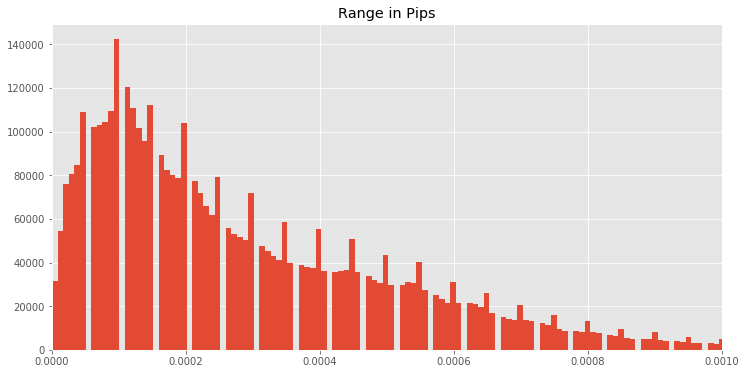

In [110]:
df['Range'].hist(bins = 2000)
plt.title('Range in Pips')
plt.xlim((0, 0.001))
plt.savefig('./output/pips_range.png', dpi=300)

In [74]:
# do we have to remove outliers?
def correctWrong(series, threshold=5):
    '''
    A helper function that returns series with variables that deviate from the mean by more than a threshold
    imputed by the mean
    '''
    series_nonnull = series[series!=0]
    mean = np.mean(series_nonnull)
    std = np.std(series_nonnull)
    
    series[series!=0] = series[series!=0].map(lambda x: x if x< (mean + threshold*std) else mean)
    
    return series

In [75]:
look = df[numerical].apply(correctWrong) #df[numerical].head()

In [92]:
#orginal with outliers
eurvolume_dataset = dataset.EURVolume
eurvolume_dataset.sort_values(ascending = False).head()

3788693    133032.40
3787397     90592.70
3788634     60701.94
4191422     48967.92
4056924     41944.64
Name: EURVolume, dtype: float64

In [90]:
eurvolume_removeoutliers = look.EURVolume #with outliers converted to mean
eurvolume_removeoutliers.sort_values(ascending = False).head()

74244      2410.20
9768       2410.20
3452170    2410.18
3375351    2410.00
11167      2409.90
Name: EURVolume, dtype: float64

In [97]:
eurvolume_log = df.EURVolume #with log1p transformation
eurvolume_log.sort_values(ascending = False).head()

3788693    11.798356
3787397    11.414140
3788634    11.013747
4191422    10.798941
4056924    10.644130
Name: EURVolume, dtype: float64

In [89]:
eurvolume_removeoutliers = look.EURVolume

### extra graphs

   Range (pips)  log1p of Range
0       0.00020         0.00020
1       0.00020         0.00020
2       0.00025         0.00025
3       0.00022         0.00022
4       0.00026         0.00026


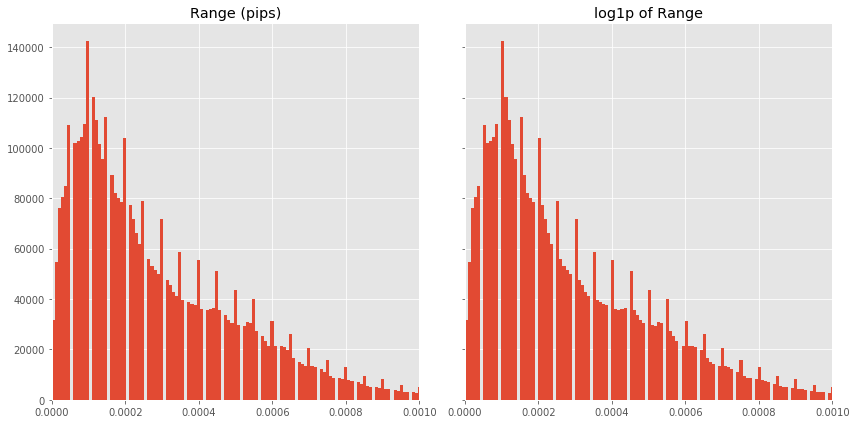

In [102]:
Range = df['Range']
Ranges = pd.DataFrame({"Range (pips)":Range, "log1p of Range":np.log1p(Range)})
print (Ranges.head())
####

matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)

n_bins = 2000

x = df['Range']
y = np.log1p(df['Range'])

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
axs[0].hist(x, bins=n_bins)
axs[1].hist(y, bins=n_bins)
axs[0].set_title('Range (pips)')
axs[1].set_title('log1p of Range')

#https://stackoverflow.com/questions/30261054/how-to-set-axes-limits-in-each-subplot
for ax in axs.flat: #this will iterate over all 6 axes
    ax.set_xlim(0, 0.001) 

#for i in range(2):
    #axs.flat[i].plot(x, u)
#    axs.flat[i].set_xlim(0, 0.001)
#    plt.title('Range and log1p(Range)')
plt.savefig('./output/price_vs_log.png', dpi=300)

It seems that the prices follow the lognormal distribution. Therefore, we will use log of prices as our response variable.

To illustrate it we plot scatter plots of Sales Price and Living Area

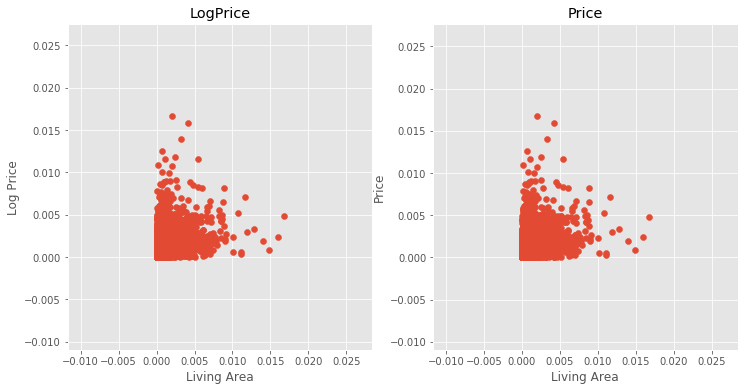

In [104]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
Ranges = pd.DataFrame({"Range (pips)":Range, "log1p of Range":np.log1p(Range)})
Ranges = Ranges.join(pd.DataFrame({'ATR5':df.ATR5}))

plt.subplot(1,2,1)
plt.scatter(Ranges['ATR5'], Ranges['log1p of Range'])
plt.ylabel('log1p of Range')
plt.xlabel('ATR5')
plt.title('log1p of Range')

plt.subplot(1,2,2)
plt.scatter(Ranges['ATR5'], Ranges['Range (pips)'])
plt.ylabel('Range (pips)')
plt.xlabel('ATR5')
plt.title('Range (pips)')

plt.savefig('./output/price_vs_log_vs_living.png', dpi=300)

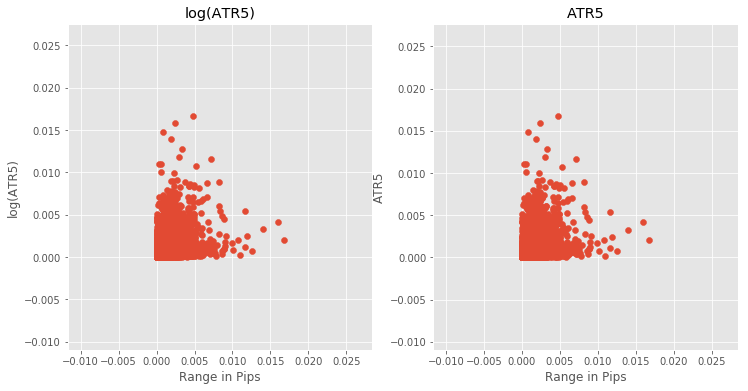

In [116]:
ATR5 = df['ATR5']
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
Ranges = pd.DataFrame({"ATR5":ATR5, "log(ATR5)":np.log1p(ATR5)})
Ranges = Ranges.join(pd.DataFrame({'Range in Pips':df.Range}))

plt.subplot(1,2,1)
plt.scatter(Ranges['Range in Pips'], Ranges['log(ATR5)'])
plt.ylabel('log(ATR5)')
plt.xlabel('Range in Pips')
plt.title('log(ATR5)')

plt.subplot(1,2,2)
plt.scatter(Ranges['Range in Pips'], Ranges['ATR5'])
plt.ylabel('ATR5')
plt.xlabel('Range in Pips')
plt.title('ATR5')

plt.savefig('./output/range_vs_ATR5_log_ATR5.png', dpi=300)

In [117]:
print (Ranges.head())

      ATR5  log(ATR5)  Range in Pips
0  0.00025    0.00025        0.00020
1  0.00018    0.00018        0.00020
2  0.00016    0.00016        0.00025
3  0.00025    0.00025        0.00022
4  0.00025    0.00025        0.00026


## Feature Engineering

Next, we look at distributions of numerical features and their skeweness.

In [22]:
skewed_feats = df[numerical].apply(lambda x: skew(x)) # compute skewness

# Select where skewenes is >0.75
skewed_feats = skewed_feats[skewed_feats>0.75]

# Get names of skewed features
sk_feat = list(skewed_feats.index.values)
skewed_feats

Body            4.958204
TopWick         2.745992
BottomWick      2.670826
EURVolume      21.957440
JPYRange        9.043138
JPYVolume      17.556915
CHFClose        0.806482
CHFRange       39.675979
CHFVolume      17.108078
XAURange        6.219982
XAUVolume       5.025303
forceindex     27.816894
ROC5            4.632115
ROC10           4.246878
MOM5            4.430771
MOM10           4.114990
ATR5            2.753177
ATR10           2.753177
ADX.DX          0.769563
ADX             1.086287
MACD            4.012424
MACD.Signal     3.957796
dtype: float64

We perform log transformation of the skewed variables

In [23]:
# Save initial values for comparison
init_skewed = df[sk_feat]

# Apply Log+1 transformation
df[sk_feat] = np.log1p(df[sk_feat])

Plot new features histograms

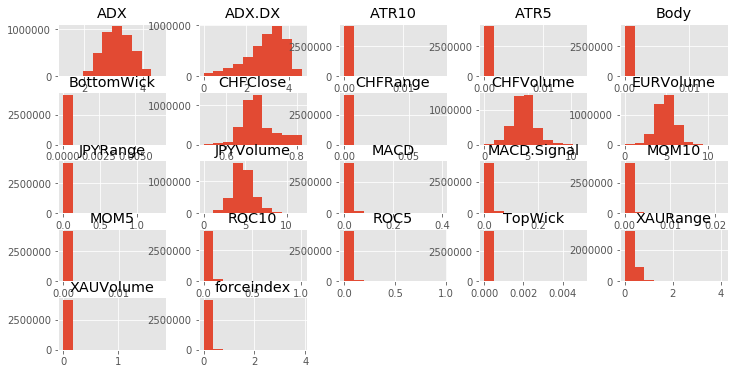

In [27]:
# Calculate skeweness
_ = df[sk_feat].hist()
plt.savefig('./output/skewed_hist.png', dpi=300)

In [24]:
log_feats = df[numerical].apply(lambda x: skew(x))
log_feats = log_feats[log_feats>0.75]
log_feats

Body            4.940050
TopWick         2.743509
BottomWick      2.666917
JPYRange        5.041732
CHFRange       37.314889
XAURange        1.610353
XAUVolume       2.402034
forceindex      5.663152
ROC5            3.595194
ROC10           3.262863
MOM5            4.411260
MOM10           4.095344
ATR5            2.740778
ATR10           2.740778
MACD            3.634538
MACD.Signal     3.612750
dtype: float64

In [138]:
# Find most important features relative to target, then take this again after log
print("Find most important features relative to target")
corr = df.corr()
corr.sort_values(["Range"], ascending = False, inplace = True)
print(corr.Range)

Find most important features relative to target
Range                1.000000
ATR5                 0.722685
ATR10                0.722685
BottomWick           0.552236
TopWick              0.514716
CHFVolume            0.467940
CHFRange             0.458303
Body                 0.432924
MOM5                 0.429507
MOM10                0.427606
JPYVolume            0.406988
ROC5                 0.404834
ROC10                0.403170
forceindex           0.385165
MACD                 0.383080
BBands.up            0.378137
Close                0.376376
BBandsm.avg          0.376356
SAR                  0.376332
BBands.dn            0.374567
JPYRange             0.365596
MACD.Signal          0.362656
CHFClose             0.305600
EURVolume            0.305001
XAURange             0.280396
ADX.DX               0.055102
ADX                  0.051251
UpCount_4.0          0.023354
UpCount_3.0          0.023275
UpCount_5.0          0.020739
                       ...   
DownCount_11.0       0

For illistration, we plot the same scatter plots but using transformed EURVolume variable.

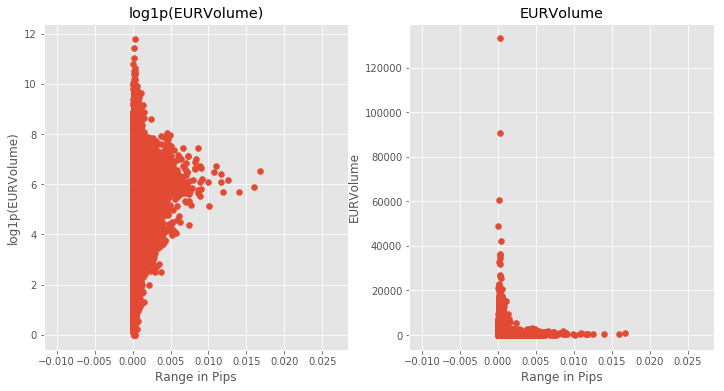

In [25]:

EURVolume = dataset['EURVolume']
logEURVolume = df["EURVolume"]
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
ranges = pd.DataFrame({"EURVolume": EURVolume, "log1pEURVolume": logEURVolume})
ranges = ranges.join(pd.DataFrame({'Range in Pips':df.Range}))

plt.subplot(1,2,1)
plt.scatter(ranges['Range in Pips'], ranges['log1pEURVolume'])
plt.ylabel('log1p(EURVolume)')
plt.xlabel('Range in Pips')
plt.title('log1p(EURVolume)')

plt.subplot(1,2,2)
plt.scatter(ranges['Range in Pips'], ranges['EURVolume'])
plt.ylabel('EURVolume')
plt.xlabel('Range in Pips')
plt.title('EURVolume')

plt.savefig('./output/range_vs_Vol_log1p_Vol.png', dpi=300)

In [26]:
# Save skewed features list
pickle.dump(sk_feat, open('./tmp/sk_feat.list', 'wb'))

## Divide into train and test sets

We divide the merged dataset into new train and test datasets, using SalePrice == 99 as a criterion. 

In [141]:
# Save the dataset
df.to_csv("./data/eur_data_cleaned.csv", index=False)

In [28]:
eur2007 = df[df['Date'].dt.year == 2007]
eur2008 = df[df['Date'].dt.year == 2008]
eur2009 = df[df['Date'].dt.year == 2009]
eur2010 = df[df['Date'].dt.year == 2010]
eur2011 = df[df['Date'].dt.year == 2011]
eur2012 = df[df['Date'].dt.year == 2012]
eur2013 = df[df['Date'].dt.year == 2013]
eur2014 = df[df['Date'].dt.year == 2014]
eur2015 = df[df['Date'].dt.year == 2015]
eur2016 = df[df['Date'].dt.year == 2016]
eur2017 = df[df['Date'].dt.year == 2017]
eur2018 = df[df['Date'].dt.year == 2018]

In [33]:
print(eur2007.shape,
eur2008.shape,
eur2009.shape,
eur2010.shape,
eur2011.shape,
eur2012.shape,
eur2013.shape,
eur2014.shape,
eur2015.shape,
eur2016.shape,
eur2017.shape,
eur2018.shape)

(341995, 85) (358238, 85) (351561, 85) (363171, 85) (362224, 85) (352007, 85) (351273, 85) (349414, 85) (350399, 85) (353045, 85) (351582, 85) (311682, 85)


### save files to csv

In [81]:
#loop for saving files
lst = ([eur2008,"eur2008"],[eur2007,"eur2007"])

for i,k in lst:
    i.to_csv("./data/%s.csv"%(k))
    
#for i in range(2007,2019):
#    print("eur%s.shape" %(i))
 
#for x in ['eur{}.shape'.format(x) for x in range(2007,2019)]:
#    print(x)

In [60]:
eur2007.to_csv('./data/eur2007.csv')
eur2008.to_csv('./data/eur2008.csv')
eur2009.to_csv('./data/eur2009.csv')
eur2010.to_csv('./data/eur2010.csv')
eur2011.to_csv('./data/eur2011.csv')

eur2012.to_csv('./data/eur2012.csv')
eur2013.to_csv('./data/eur2013.csv')
eur2014.to_csv('./data/eur2014.csv')
eur2015.to_csv('./data/eur2015.csv')
eur2016.to_csv('./data/eur2016.csv')

eur2017.to_csv('./data/eur2017.csv')
eur2018.to_csv('./data/eur2018.csv')

### for loop to upload files to s3 bucket

In [90]:
bucketName = "capstoneproject-770851433061"
s3 = boto3.client('s3')

lst_names = ["eur2007.csv", "eur2008.csv", "eur2009.csv", "eur2010.csv", "eur2011.csv", "eur2012.csv", "eur2013.csv", 
             "eur2014.csv", "eur2015.csv", "eur2016.csv", "eur2017.csv", "eur2018.csv"]

for i in lst_names :
    s3.upload_file("./data/%s"%(i),bucketName,i)

In [87]:
lst_names = ["eur2007.csv", "eur2008.csv", "eur2009.csv", "eur2010.csv", "eur2011.csv", "eur2012.csv", "eur2013.csv", 
             "eur2014.csv", "eur2015.csv", "eur2016.csv", "eur2017.csv", "eur2018.csv"]

for i in lst_names :
    print("./data/%s"%(i))

./data/eur2007.csv
./data/eur2008.csv
./data/eur2009.csv
./data/eur2010.csv
./data/eur2011.csv
./data/eur2012.csv
./data/eur2013.csv
./data/eur2014.csv
./data/eur2015.csv
./data/eur2016.csv
./data/eur2017.csv
./data/eur2018.csv


In [86]:
lst = [eur2007, eur2008, eur2009, eur2010, eur2011, eur2012, eur2013, eur2014, eur2015, eur2016, eur2017, eur2018]
lst_names = ["eur2007.csv", "eur2008.csv", "eur2009.csv", "eur2010.csv", "eur2011.csv", "eur2012.csv", "eur2013.csv", 
             "eur2014.csv", "eur2015.csv", "eur2016.csv", "eur2017.csv", "eur2018.csv"]

zipped = zip(lst, lst_names)


In [91]:
df.head()

,Range,Date,Timestamp,Close,Body,TopWick,BottomWick,EURVolume,JPYClose,JPYRange,JPYVolume,CHFClose,CHFRange,CHFVolume,XAUClose,XAURange,XAUVolume,forceindex,WillR5,WillR10,WillR15,RSI5,RSI10,RSI15,ROC5,ROC10,MOM5,MOM10,ATR5,ATR10,ADX.DIp,ADX.DIn,ADX.DX,ADX,SAR,Stoch.fastK,Stoch.fastD,Stoch.slowD,BBands.dn,BBandsm.avg,BBands.up,BBands.pctB,MACD,MACD.Signal,UpCount_2.0,UpCount_3.0,UpCount_4.0,UpCount_5.0,UpCount_6.0,UpCount_7.0,UpCount_8.0,UpCount_9.0,UpCount_10.0,UpCount_11.0,UpCount_12.0,UpCount_13.0,UpCount_14.0,UpCount_15.0,UpCount_16.0,UpCount_17.0,UpCount_18.0,UpCount_19.0,UpCount_0,DownCount_2.0,DownCount_3.0,DownCount_4.0,DownCount_5.0,DownCount_6.0,DownCount_7.0,DownCount_8.0,DownCount_9.0,DownCount_10.0,DownCount_11.0,DownCount_12.0,DownCount_13.0,DownCount_14.0,DownCount_15.0,DownCount_16.0,DownCount_17.0,DownCount_18.0,DownCount_19.0,DownCount_20.0,DownCount_21.0,DownCount_0,MACD.Signal2_Sell
0,0.00020,2006-12-31,19:33:00,1.31901,0.00009,0.00009,0.00007,6.754254,119.020,0.012916,5.459160,0.796980,0.00005,4.389499,635.490,0.508022,0.020900,0.074275,0.857143,0.857143,0.857143,27.601810,35.618480,40.270270,0.009807,0.009056,0.00013,0.00012,0.00025,0.00025,12.388902,17.454997,2.888999,2.640082,1.319430,0.142857,0.301192,0.372923,1.318985,1.319258,1.319531,0.113396,0.007122,0.007884,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.00020,2006-12-31,19:40:00,1.31925,0.00008,0.00004,0.00006,6.821435,119.025,0.008960,5.987708,0.796989,0.00015,4.845761,635.492,0.509825,0.018557,0.070742,0.210526,0.367347,0.367347,61.344538,55.900621,54.107143,0.000000,0.000758,0.00000,0.00001,0.00018,0.00018,11.809940,15.745073,2.726611,2.502415,1.319308,0.632653,0.527385,0.498155,1.319057,1.319191,1.319325,0.595242,0.004229,0.005557,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0.00025,2006-12-31,19:42:00,1.31918,0.00009,0.00005,0.00002,6.058422,119.025,0.016857,5.778271,0.796944,0.00015,4.730921,635.676,0.459322,0.020508,0.037684,0.378378,0.384615,0.510204,50.000000,50.904393,49.298597,0.006046,0.001515,0.00008,0.00002,0.00016,0.00016,11.165577,14.348379,2.600818,2.553287,1.318940,0.489796,0.488989,0.491079,1.319064,1.319192,1.319321,0.607481,0.003902,0.004999,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.00022,2006-12-31,19:43:00,1.31910,0.00004,0.00016,0.00005,6.850338,119.008,0.019803,5.231109,0.796962,0.00013,5.387701,635.583,0.515216,0.018537,0.037034,0.594595,0.605263,0.673469,34.313725,40.259740,43.425076,0.000758,0.006800,0.00001,0.00009,0.00025,0.00025,10.307095,16.628187,3.197354,2.667116,1.318940,0.326531,0.407760,0.449419,1.319073,1.319195,1.319317,0.315182,0.004153,0.004830,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.00026,2006-12-31,19:44:00,1.31928,0.00014,0.00007,0.00001,6.709792,119.023,0.005982,5.163642,0.796976,0.00008,4.850467,635.550,0.455524,0.007323,0.108600,0.233333,0.175000,0.306122,68.553459,59.795918,56.502242,0.012056,0.008304,0.00016,0.00011,0.00025,0.00025,11.048303,15.356645,2.851655,2.693780,1.318955,0.693878,0.550819,0.500119,1.319073,1.319198,1.319322,0.723803,0.003217,0.004508,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [93]:
df.shape

(4196698, 85)

In [94]:
df.to_csv('./data/eurfinal_cleaned.csv') #

In [96]:
s3.upload_file("./data/eurfinal_cleaned.csv",bucketName,"eurfinal_cleaned.csv")

## Get 2007 Data to Start With Predictions

In [98]:
eur2007.shape

(341995, 85)

In [100]:
341995*0.3

102598.5

In [101]:
#70% train-set and a 30% test-set
np.random.seed(1)
testIdxes = np.random.choice(range(341995), size= 102600, replace=False)
trainIdxes = list(set(range(341995))-set(testIdxes))
trainX = eur2007.iloc[trainIdxes]
testX  = eur2007.iloc[testIdxes]
#trainY = totalbill.iloc[trainIdxes]
#testY  = totalbill.iloc[testIdxes]

In [103]:
print (trainX.shape)
trainX.head()

(239395, 85)


,Range,Date,Timestamp,Close,Body,TopWick,BottomWick,EURVolume,JPYClose,JPYRange,JPYVolume,CHFClose,CHFRange,CHFVolume,XAUClose,XAURange,XAUVolume,forceindex,WillR5,WillR10,WillR15,RSI5,RSI10,RSI15,ROC5,ROC10,MOM5,MOM10,ATR5,ATR10,ADX.DIp,ADX.DIn,ADX.DX,ADX,SAR,Stoch.fastK,Stoch.fastD,Stoch.slowD,BBands.dn,BBandsm.avg,BBands.up,BBands.pctB,MACD,MACD.Signal,UpCount_2.0,UpCount_3.0,UpCount_4.0,UpCount_5.0,UpCount_6.0,UpCount_7.0,UpCount_8.0,UpCount_9.0,UpCount_10.0,UpCount_11.0,UpCount_12.0,UpCount_13.0,UpCount_14.0,UpCount_15.0,UpCount_16.0,UpCount_17.0,UpCount_18.0,UpCount_19.0,UpCount_0,DownCount_2.0,DownCount_3.0,DownCount_4.0,DownCount_5.0,DownCount_6.0,DownCount_7.0,DownCount_8.0,DownCount_9.0,DownCount_10.0,DownCount_11.0,DownCount_12.0,DownCount_13.0,DownCount_14.0,DownCount_15.0,DownCount_16.0,DownCount_17.0,DownCount_18.0,DownCount_19.0,DownCount_20.0,DownCount_21.0,DownCount_0,MACD.Signal2_Sell
107,0.00021,2007-01-01,00:00:00,1.31926,0.00016,0.00000,0.00002,5.798790,119.013,0.002996,4.554929,0.796967,0.00006,3.945458,635.665,0.472501,0.023130,0.051286,0.360000,0.360000,0.360000,47.058824,50.246305,53.617021,0.000000,0.003783,0.00000,0.00005,0.00018,0.00018,12.303177,13.411366,1.669513,2.510724,1.318940,0.640000,0.683297,0.682029,1.319097,1.319218,1.319340,0.862827,0.001270,0.000161,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
109,0.00025,2007-01-01,00:04:00,1.31928,0.00004,0.00008,0.00011,6.326149,119.003,0.016857,5.877175,0.796962,0.00012,4.980176,635.850,0.511625,0.027187,0.022075,0.437500,0.320000,0.320000,47.619048,51.566952,52.447552,0.003783,0.004538,0.00005,0.00006,0.00023,0.00023,9.502663,14.980888,3.151672,2.715814,1.318995,0.680000,0.667706,0.678039,1.319133,1.319243,1.319352,0.685356,0.001386,0.000952,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
110,0.00021,2007-01-01,00:05:00,1.31943,0.00010,0.00000,0.00015,6.444767,119.013,0.012916,5.866185,0.796953,0.00010,4.856707,635.869,0.468753,0.019548,0.060945,0.000000,0.020000,0.020000,75.510204,67.734554,62.824507,0.012804,0.012804,0.00017,0.00017,0.00025,0.00025,9.685523,13.883957,2.934549,2.747894,1.319012,0.980000,0.823853,0.750946,1.319160,1.319255,1.319351,0.978845,0.002271,0.001216,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
112,0.00022,2007-01-01,00:11:00,1.31928,0.00003,0.00012,0.00005,6.784457,119.012,0.009950,5.259057,0.796948,0.00015,4.612146,635.756,0.541161,0.025882,0.026145,0.619048,0.454545,0.306122,50.000000,47.696477,49.268293,0.001515,0.001515,0.00002,0.00002,0.00020,0.00020,7.067564,12.665037,3.379859,2.995687,1.319142,0.545455,0.631250,0.668928,1.319215,1.319284,1.319354,0.564710,0.001294,0.001408,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
114,0.00020,2007-01-01,00:13:00,1.31935,0.00005,0.00005,0.00007,6.907055,119.017,0.006976,5.712081,0.796967,0.00012,5.249127,635.687,0.523544,0.019803,0.048709,0.260870,0.307692,0.242424,59.183673,56.464380,54.032258,0.002271,0.009806,0.00003,0.00013,0.00017,0.00017,6.206984,11.727059,3.458833,3.132498,1.319175,0.757576,0.763873,0.741711,1.319218,1.319288,1.319358,0.777535,0.002027,0.001609,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [104]:
print (testX.shape)
testX.head()

(102600, 85)


,Range,Date,Timestamp,Close,Body,TopWick,BottomWick,EURVolume,JPYClose,JPYRange,JPYVolume,CHFClose,CHFRange,CHFVolume,XAUClose,XAURange,XAUVolume,forceindex,WillR5,WillR10,WillR15,RSI5,RSI10,RSI15,ROC5,ROC10,MOM5,MOM10,ATR5,ATR10,ADX.DIp,ADX.DIn,ADX.DX,ADX,SAR,Stoch.fastK,Stoch.fastD,Stoch.slowD,BBands.dn,BBandsm.avg,BBands.up,BBands.pctB,MACD,MACD.Signal,UpCount_2.0,UpCount_3.0,UpCount_4.0,UpCount_5.0,UpCount_6.0,UpCount_7.0,UpCount_8.0,UpCount_9.0,UpCount_10.0,UpCount_11.0,UpCount_12.0,UpCount_13.0,UpCount_14.0,UpCount_15.0,UpCount_16.0,UpCount_17.0,UpCount_18.0,UpCount_19.0,UpCount_0,DownCount_2.0,DownCount_3.0,DownCount_4.0,DownCount_5.0,DownCount_6.0,DownCount_7.0,DownCount_8.0,DownCount_9.0,DownCount_10.0,DownCount_11.0,DownCount_12.0,DownCount_13.0,DownCount_14.0,DownCount_15.0,DownCount_16.0,DownCount_17.0,DownCount_18.0,DownCount_19.0,DownCount_20.0,DownCount_21.0,DownCount_0,MACD.Signal2_Sell
227657,0.00063,2007-09-03,10:42:00,1.36233,0.00010,0.00004,0.00019,6.816298,115.850,0.009950,7.269129,0.792200,0.00020,7.235331,671.345,0.090754,0.005077,0.087241,0.618421,0.654762,0.654762,44.15584,43.97363,45.57762,0.018181,0.010223,0.00025,0.00014,0.00033,0.00033,4.122643,9.864302,3.738862,3.141767,1.362814,0.345238,0.329285,0.352987,1.362242,1.362447,1.362652,0.173069,0.001292,0.000371,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
7177,0.00058,2007-01-08,17:11:00,1.30221,0.00006,0.00007,0.00010,6.740992,118.758,0.036332,5.730749,0.804702,0.00025,5.548687,608.923,0.517006,0.016316,0.049479,0.368421,0.297872,0.254545,61.32075,63.88889,59.11215,0.002301,0.017511,0.00003,0.00023,0.00023,0.00023,9.437096,13.990470,3.017297,3.137782,1.301880,0.745455,0.731421,0.696129,1.301956,1.302112,1.302268,0.717680,0.002069,0.001368,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
270657,0.00033,2007-10-17,10:26:00,1.42173,0.00022,0.00018,0.00007,7.060691,116.630,0.029559,7.550872,0.779050,0.00020,7.300473,760.591,0.287432,0.005863,0.228040,0.273973,0.246914,0.227273,59.81013,56.02837,56.55696,0.006311,0.017434,0.00009,0.00025,0.00047,0.00047,7.328730,10.270220,2.874355,2.841387,1.421184,0.772727,0.712364,0.709458,1.421295,1.421520,1.421745,0.885863,0.002130,0.000834,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
71194,0.00028,2007-03-15,09:35:00,1.32241,0.00018,0.00004,0.00002,6.769297,117.174,0.027615,5.349961,0.796069,0.00039,4.304065,644.639,0.630207,0.025073,0.145438,0.607843,0.789474,0.878788,51.45631,37.19943,33.41609,0.006782,0.031256,0.00009,0.00042,0.00024,0.00024,20.882360,26.297180,2.523891,2.353964,1.323391,0.121212,0.103988,0.115747,1.321889,1.322747,1.323605,0.272412,0.002032,0.004607,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
168641,0.00027,2007-07-02,01:58:00,1.35387,0.00006,0.00000,0.00000,5.777652,123.000,0.009950,5.350435,0.798318,0.00010,5.826885,648.741,0.192272,0.003474,0.019136,0.808511,0.550725,0.457831,17.44966,45.80537,54.78469,0.018294,0.016122,0.00025,0.00022,0.00009,0.00009,30.228800,26.421240,2.043969,3.133571,1.354250,0.542169,0.597550,0.670144,1.353266,1.353745,1.354223,0.651923,0.007311,0.006227,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [105]:
# Save new test and train sets
testX.to_csv('./data/new_test.csv')
trainX.to_csv('./data/new_train.csv')

In [ ]:
## Separate into training and test datasets

import sklearn.model_selection as ms
from sklearn import datasets
iris = datasets.load_iris()
x_train, x_test, y_train, y_test = ms.train_test_split(iris.data, iris.target, 
                                                       test_size=1.0/3, random_state=0)
print('Original: {}, {}'.format(iris.data.shape, iris.target.shape))
print('Training: {}, {}'.format(x_train.shape, y_train.shape))
print('Test: {}, {}'.format(x_test.shape, y_test.shape))

In [29]:
new_train = df.loc[df['SalePrice']!=99,:]
new_test = df.loc[df['SalePrice']==99,:].copy()
new_test.drop('SalePrice', axis=1, inplace=True)



print(new_train.shape)
print(new_test.shape)

assert(test.shape[0]==new_test.shape[0])

(1460, 280)
(1459, 279)


In [30]:
# Save new test and train sets
new_test.to_csv('./data/new_test.csv')
new_train.to_csv('./data/new_train.csv')